In [1]:
## Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from tkinter import Tk
import tkinter
import imagecodecs
from tkinter.filedialog import askopenfilename
import os
from skimage import filters, measure, morphology

In [2]:
tkinter._test()

In [3]:
# Use tkinter to open a file dialog and select one of the images
def select_file():
    Tk().withdraw()  # We don't want a full GUI, so keep the root window from appearing
    filename = askopenfilename(title="Select a Channel 1 TIFF Image", filetypes=[("TIFF files", "*.tif *.tiff")])
    return filename

# Select a file using the file dialog
selected_file = select_file()

In [4]:
# Generate filenames for the other channels based on the selected file
base_name = os.path.splitext(selected_file)[0]
channel1_path = selected_file
channel2_path = base_name.replace("CH1", "CH2") + os.path.splitext(selected_file)[1]
channel3_path = base_name.replace("CH1", "CH3") + os.path.splitext(selected_file)[1]
channel4_path = base_name.replace("CH1", "CH4") + os.path.splitext(selected_file)[1]

# Load the images
channel1 = tiff.imread(channel1_path)
channel2 = tiff.imread(channel2_path)
channel3 = tiff.imread(channel3_path)
channel4 = tiff.imread(channel4_path)

# Combine channels into a single multi-channel image for convenience
image = np.stack((channel1, channel2, channel3, channel4), axis=-1)


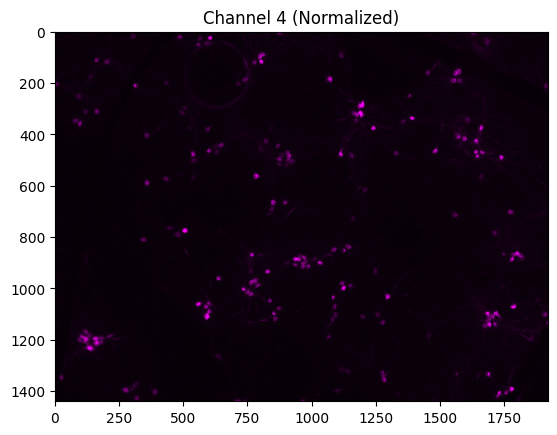

In [5]:

# Normalize images for display
def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

# Display one of the channels (normalized)
plt.imshow(normalize(channel4), cmap='gray')
plt.title('Channel 4 (Normalized)')
plt.show()

In [ ]:
# Find minima below a threshold to define background ROIs
background_threshold = 1000  # Adjust this value based on your needs
_, background_thresh = cv2.threshold(channel4, background_threshold, 255, cv2.THRESH_BINARY_INV)

# Find contours of the background regions
background_contours, _ = cv2.findContours(background_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create bounding boxes around the detected background contours to define background ROIs
background_rois = []

for contour in background_contours:
    x, y, w, h = cv2.boundingRect(contour)
    background_rois.append((x, y, w, h))

# Display background ROIs on channel 1
background_roi_image = cv2.cvtColor(channel4, cv2.COLOR_GRAY2BGR)

for roi in background_rois:
    x, y, w, h = roi
    cv2.rectangle(background_roi_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.imshow(background_roi_image)
plt.title('Background ROIs on Channel 4')
plt.show()


In [ ]:

# Initialize a list to store mean fluorescence values
mean_fluorescence = {f'Channel {i+1}': [] for i in range(image.shape[2])}
background_values = {f'Channel {i+1}': [] for i in range(image.shape[2])}

# Calculate mean background values for each channel
for channel_index in range(image.shape[2]):
    channel = image[:, :, channel_index]
    
    for roi in background_rois:
        x, y, w, h = roi
        roi_area = channel[y:y+h, x:x+w]
        mean_background = np.mean(roi_area)
        background_values[f'Channel {channel_index+1}'].append(mean_background)

# Subtract background from the entire image
background_subtracted_image = np.copy(image)
for channel_index in range(image.shape[2]):
    mean_background_value = np.mean(background_values[f'Channel {channel_index+1}'])
    background_subtracted_image[:, :, channel_index] -= mean_background_value


In [ ]:

# Find minimum and maximum in channel 4 to define a background and a ROI section
minimum_threshold = 40  # Adjust threshold value as needed
# Apply a threshold to find minimum values in channel 1
_, background_thresh = cv2.threshold(channel4, minimum_threshold, 255, cv2.THRESH_BINARY)  

maximum_threshold = 200  # Adjust threshold value as needed

# Apply a threshold to find maximum values in channel 1
_, thresh = cv2.threshold(channel1, maximum_threshold, 255, cv2.THRESH_BINARY)

# Find contours of the thresholded regions
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Display the detected contours on channel 1
contour_image = cv2.cvtColor(channel1, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

plt.imshow(contour_image)
plt.title('Detected Contours on Channel 1')
plt.show()

# Create bounding boxes around the detected contours to define ROIs
rois = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    rois.append((x, y, w, h))

# Display ROIs on channel 1
roi_image = cv2.cvtColor(channel1, cv2.COLOR_GRAY2BGR)

for roi in rois:
    x, y, w, h = roi
    cv2.rectangle(roi_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(roi_image)
plt.title('ROIs on Channel 1')
plt.show()


In [ ]:

# Initialize a list to store mean fluorescence values
mean_fluorescence = {f'Channel {i+1}': [] for i in range(image.shape[2])}

# Iterate over all channels
for channel_index in range(image.shape[2]):
    channel = image[:, :, channel_index]
    
    for roi in rois:
        x, y, w, h = roi
        roi_area = channel[y:y+h, x:x+w]
        mean_value = np.mean(roi_area)
        mean_fluorescence[f'Channel {channel_index+1}'].append(mean_value)

# Print the results
for channel, values in mean_fluorescence.items():
    print(f'{channel}: {values}')